In [6]:
'''
OPENMATH eval
'''


from dataset import OpenMathDataset
import json
from utils import find_and_parse_json


not_json_mode_path = '/Users/arnaudstiegler/back-office-llm-bench/openai_predictions/open_math/predictions_not_json_mode.json'
json_mode_path = '/Users/arnaudstiegler/back-office-llm-bench/openai_predictions/open_math/predictions_json_mode.json'


preds = json.load(open(json_mode_path))
dataset = OpenMathDataset(json_mode=False)
contains_json = []
correct_json = []
correct_answer = []
for i in range(len(preds)):
    answer = preds[i]['choices'][0]['message']['content']
    # Starts at 1
    sample = dataset[i+1]

    json_dict = find_and_parse_json(answer)

    if not json_dict:
        contains_json.append(0)
    else:
        contains_json.append(1)

        if not set(json_dict.keys()) == {'answer'}:
            correct_json.append(0)
        else:
            correct_json.append(1)

            if str(json_dict['answer']) == str(sample.answer):
                correct_answer.append(1)
            else:
                correct_answer.append(0)

print('contains parsable json: ', sum(contains_json) / len(contains_json))
print('json dict has the valid format: ', sum(correct_json) / len(correct_json))
print('accuracy on the valid answers: ', sum(correct_answer) / len(correct_answer))

contains parsable json:  0.494
json dict has the valid format:  1.0
accuracy on the valid answers:  0.402834008097166


In [5]:
'''
KLEISTER NDA 
'''


from dataset import KleisterNdaDataset
import json
not_json_mode_path = '/Users/arnaudstiegler/back-office-llm-bench/openai_predictions/kleister_nda/predictions_not_json_mode.json'
json_mode_path = '/Users/arnaudstiegler/back-office-llm-bench/openai_predictions/kleister_nda/predictions_json_mode.json'


preds = json.load(open(json_mode_path))
dataset = KleisterNdaDataset(json_mode=True)
contains_json = []
correct_json = []
correct_answer = []
for i in range(len(preds)):
    answer = preds[i]['choices'][0]['message']['content']
    sample = preds[i]['sample']

    json_dict = find_and_parse_json(answer)

    if not json_dict:
        contains_json.append(0)
    else:
        contains_json.append(1)

        # if not set(json_dict.keys()) == {'answer'}:
        if not set(json_dict.keys()) == {"effective_date","jurisdiction","party","term"}:
            correct_json.append(0)
        else:
            correct_json.append(1)

            # if str(json_dict['answer']) == str(sample.answer):
            answer = json.loads(sample['answer'])
            for key in answer.keys():
                if isinstance(json_dict[key], str):
                    if json_dict[key] == answer[key]:
                # if json_dict == sample.answer:
                        correct_answer.append(1)
                    else:
                        # print(json_dict[key], answer[key])
                        correct_answer.append(0)
                elif isinstance(json_dict[key], list):
                    pred_set = {elem.lower().replace(".","").replace(",","") for elem in json_dict[key]}

                    if isinstance(answer[key], str):
                        answer[key] = [answer[key]]
                    answer_set = {elem.lower().replace(".","").replace(",","") for elem in answer[key]}
                    if pred_set == answer_set:
                        correct_answer.append(1)
                    else:
                        # print(pred_set, answer_set)
                        correct_answer.append(0)

print('contains parsable json: ', sum(contains_json) / len(contains_json))
print('json dict has the valid format: ', sum(correct_json) / len(correct_json))
print('accuracy on the valid answers: ', sum(correct_answer) / len(correct_answer))

contains parsable json:  0.9920948616600791
json dict has the valid format:  1.0
accuracy on the valid answers:  0.8


In [2]:
'''
MultiHopQA 
'''


from dataset import MultiHopQADataset
import json
from utils import find_and_parse_json
not_json_mode_path = '/Users/arnaudstiegler/back-office-llm-bench/openai_predictions/multi_hop_qa/predictions_not_json_mode.json'
json_mode_path = '/Users/arnaudstiegler/back-office-llm-bench/openai_predictions/multi_hop_qa/predictions_json_mode.json'

from openai import OpenAI

SYS_PROMPT = (
    "You are an AI agent used for automation. Do not act like a chatbot. Execute the task and"
    "follow the instructions for the formatting of the output."
)
client = OpenAI()

json_mode = True
preds = json.load(open(json_mode_path if json_mode else not_json_mode_path))
dataset = MultiHopQADataset(json_mode=False)
contains_json = []
correct_json = []
correct_answer = []
for i in range(len(preds)):
    answer = preds[i]['choices'][0]['message']['content']
    sample = preds[i]['sample']

    json_dict = find_and_parse_json(answer)

    if not json_dict:
        contains_json.append(0)
        # print(answer)
        # print('======')
    else:
        contains_json.append(1)

        # if not set(json_dict.keys()) == {'answer'}:
        if not set(json_dict.keys()) == {"answer"}:
            correct_json.append(0)
        else:
            correct_json.append(1)

            prompt = (f'first answer: {sample["answer"]}, second answer: {json_dict["answer"]}. Are those 2 answers refering to the same thing? '
            'The two answers do not need to be exactly the same but they need to point to the same information.'
            'For instance, if the 2 answers are date but one is just the year and the other is the full date, still count it as true.'
            'If one answer is only a subset of the other one, you can count it as true as well.'
            'Otherwise, formatting also do not matter when it comes to comparing answers, it just matter what the info is and not how it is formatted'
            'Answer either yes or no and nothing else. Just yes or no')
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": SYS_PROMPT},
                    {"role": "user", "content": prompt},
                ],
                # response_format={"type": "json_object"},
            )
            if 'yes' in response.choices[0].message.content.lower():
                correct_answer.append(1)
            elif 'no' in response.choices[0].message.content.lower():
                correct_answer.append(0)
                # print(json_dict['answer'], sample['answer'])
            else:
                import ipdb; ipdb.set_trace()
    

print('contains parsable json: ', sum(contains_json) / len(contains_json))
print('json dict has the valid format: ', sum(correct_json) / len(correct_json))
print('accuracy on the valid answers: ', sum(correct_answer) / len(correct_answer))

contains parsable json:  0.99
json dict has the valid format:  1.0
accuracy on the valid answers:  0.27474747474747474


In [32]:
# answer="{'effective_date': '2001-04-18', 'jurisdiction': 'Oregon', 'party': ['Eric_Dean_Sprunk', 'Nike_Inc.']}"

prompt = '''
The text above is the transcription of an NDA. 

# Extraction:
There are up to 6 attributes to be extracted from the transcription:

effective_date - date in YYYY-MM-DD format, at which point the contract is legally binding,
jurisdiction - under which state or country jurisdiction is the contract signed,
party - party or parties of the contract,
term - length of the legal contract as expressed in the document.
Note that party usually occur more than once.

# Normalization:
The expected pieces of information were normalized to some degree:

in attribute values, all spaces   and colons : were replaced with an underscores _,
all expected dates should be returned in YYYY-MM-DD format,
values for attribute term are normalized with the same original units e.g. eleven months is changed to 11_months; all of them are in the same format: {number}_{units}.
For jurisdiction, only return the state name and nothing else. For instance, return "California" instead of "State_of_California"

# Output Format:
The output has to be a valid json with the following format:
{"effective_date": "value", "jurisdiction":"value", "party":["value_1", "value_2", ...], "term":"value"}

So for instance:
"{'effective_date': '2020-01-12', 'jurisdiction': 'Utah', 'party': ['Bill_Gates', 'Coca_Cola_Inc.']}"

You can reason and explain your choices before returning the JSON object, you just have to have that json object in the output
'''

In [1]:
from dataset import MultiHopQADataset

dataset = MultiHopQADataset(json_mode=False)

In [2]:
dataset[1].prompt

'What were the biggest terrorist attacks by the group Bush declared war against in the country with the world\'s largest economy in 2014?  \n  \n        Answer the question and return a JSON object with a key "answer" and the value being the answer\n        to the question. Do not put any explanation of any sort in the Json object, only the actual\n        answer to the question.\n        \n        For instance, if the question is: what is the capital of the country with the largest GDP in the world?\n        The output would be:\n        {"answer": "USA"}\n        Typically, the answer should only be a few words and not a sentence.\n        Also, do not put " or \' in the value of the JSON because that prevents me from parsing the json within the string.\n         Think step by step. First write the reasoning to get to the answer, then write the Json object containing only the answer'

In [24]:
from openai import OpenAI

SYS_PROMPT = (
    "You are an AI agent used for automation. Do not act like a chatbot. Execute the task and"
    "follow the instructions for the formatting of the output as a JSON object."
)
client = OpenAI(api_key=api_key)
response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": SYS_PROMPT},
            {"role": "user", "content": dataset[1].prompt},
        ],
        # response_format={"type": "json_object"},
    )

In [25]:
find_and_parse_json(response.choices[0].message.content)

{'answer': 'Not applicable'}

In [26]:
response.choices[0].message.content

'- The group that Bush declared war against is Al-Qaeda.\n- The country with the world\'s largest economy in 2014 was the United States.\n- The biggest terrorist attack by Al-Qaeda in the United States in 2014 was not applicable as there were no major attacks by Al-Qaeda in the United States during that year.\n\n```json\n{"answer": "Not applicable"}\n``` '

In [27]:
dataset[1].answer

'the 9/11 attacks'

In [28]:
dataset[1].prompt

'What were the biggest terrorist attacks by the group Bush declared war against in the country with the world\'s largest economy in 2014?  \n  \n        Answer the question and return a JSON object with a key "answer" and the value being the answer\n        to the question. Do not put any explanation of any sort in the Json object, only the actual\n        answer to the question.\n        \n        For instance, if the question is: what is the capital of the country with the largest GDP in the world?\n        The output would be:\n        {"answer": "USA"}\n        Typically, the answer should only be a few words and not a sentence.\n        \n         Think step by step. First write the reasoning to get to the answer, then write the Json object containing only the answer'

In [55]:
# 'multihop': True
# 'question': 'What is the dosage for Advil?',
# 'unanswerable': None
# 'answer': 'Molotov -- Ribbentrop Pact of 1939'
sample.keys()

dict_keys(['multihop', 'meta_info', 'final_answer', 'question', 'answer', 'tag', 'sub_questions'])

In [63]:
x = [sample for sample in dataset['train'] if sample['answer']]

In [64]:
'''
Reason and answer the question above.
The return should be a json object, with one key "answer" and the corresponding value should be the answer to the question.
'''

6976

In [68]:
x[3]

{'multihop': True,
 'meta_info': {'attribute_1': None,
  'attribute_2': None,
  'category': None,
  'comparison_attribute': None,
  'entity': None,
  'entity_1': None,
  'entity_2': None,
  'index': None,
  'list_of_attributes': None,
  'llm': 'wizard_lm',
  'negatives': None,
  'selected': None,
  'slot_dic': None,
  'src': 'un_musicque'},
 'final_answer': 'Summary: The knowledge provided does not contain any information about the expansion of a single reed\'s role or any composer who might have done so. There is no mention of any piece of music that is used as a cliché to convey refinement in relation to this topic. The knowledge only pertains to Thomas & Friends and Far East Movement\'s song "The Illest." Without any information about the composer or the piece of music in question, it is impossible to generate a reasoning to answer this question. The knowledge provided does not offer any context or hints that could lead to a potential answer.\nAnswer: I\'m sorry, but I cannot answer

In [69]:
x[3]['question']

"What piece, by the composer who expanded the single reeds' role, is used as a cliché to convey refinement?"

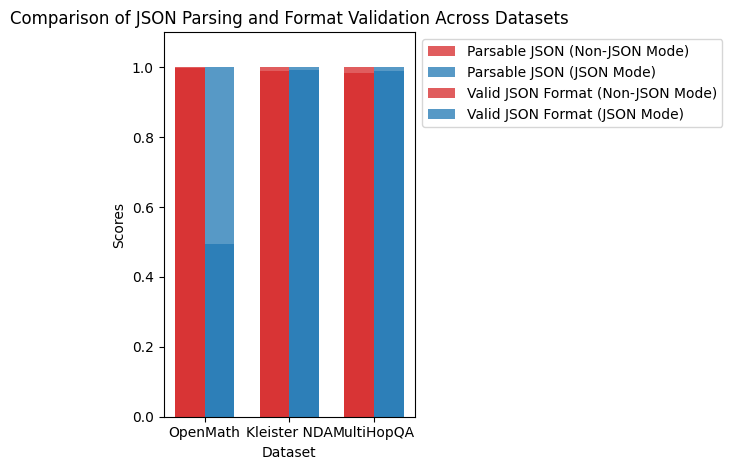

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset names
datasets = ['OpenMath', 'Kleister NDA', 'MultiHopQA']

# Colors for Non-JSON and JSON mode bars
colors = ['#D62728', '#1F77B4']  # Red and blue, respectively

# Data: [Not JSON Mode, JSON Mode] for each dataset and category
# Categories are now explicitly defined in the plotting section
values = np.array([
    [[0.997, 1.0], [0.494, 1.0]],  # OpenMath
    [[0.9881422924901185, 1.0], [0.9920948616600791, 1.0]],  # Kleister NDA
    [[0.984, 1.0], [0.99, 1.0]]  # MultiHopQA
])

n_datasets = len(datasets)
index = np.arange(n_datasets)
bar_width = 0.35

fig, ax = plt.subplots()

# Plotting bars for each dataset and category
for i, category in enumerate(['Parsable JSON', 'Valid JSON Format']):
    # Extracting not_json_mode and json_mode values for the current category
    values_not_json_mode = values[:, 0, i]
    values_json_mode = values[:, 1, i]
    
    # Creating bars for Non-JSON and JSON modes
    ax.bar(index - bar_width/2, values_not_json_mode, bar_width, label=f'{category} (Non-JSON Mode)', color=colors[0], alpha=0.75)
    ax.bar(index + bar_width/2, values_json_mode, bar_width, label=f'{category} (JSON Mode)', color=colors[1], alpha=0.75)

# Setting chart titles and labels
ax.set_xlabel('Dataset')
ax.set_ylabel('Scores')
ax.set_title('Comparison of JSON Parsing and Format Validation Across Datasets')
ax.set_xticks(index)
ax.set_xticklabels(datasets)

# Adjusting the legend to be outside of the graph
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.ylim(0, 1.1)  # Extend y-axis to fit legends properly
plt.tight_layout()
plt.show()
